In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## 1. Loading and Normalizing Data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
          'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

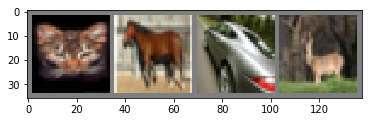

Ground-truth:   cat horse   car  deer


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Get random images
dataIterator = iter(trainloader)
images, labels = dataIterator.next()

# Show images
imshow(torchvision.utils.make_grid(images))
print('Ground-truth:', ' '.join('%5s' % classes[labels[j]] for j in range(labels.shape[0])))

## 2. Define a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Define convolutional layers [In_channels, out_channels, filter_size]
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Define dense layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def num_flat_features(self, x):
        size = x.size()[1:] # Discard the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
    def forward(self, x):
        # Add the convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the network
        x = x.view(-1, self.num_flat_features(x))
        
        # Add the dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
# Initialize the network
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 3. Define the loss function and the optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

In [7]:
num_epochs = 2
print_iter = 2000

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # Get the data
        inputs, labels = data
        
        # Reset the gradients
        optimizer.zero_grad()
        
        # Backprop the loss through the network
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if i % print_iter == print_iter - 1:
            print('[%d, %5d] Loss: %.3f' % (epoch + 1, i + 1, running_loss / print_iter))
            running_loss = 0.0
        
print("Finished training!")

[1,  2000] Loss: 2.223
[1,  4000] Loss: 1.973
[1,  6000] Loss: 1.722
[1,  8000] Loss: 1.639
[1, 10000] Loss: 1.564
[1, 12000] Loss: 1.504
[2,  2000] Loss: 1.428
[2,  4000] Loss: 1.419
[2,  6000] Loss: 1.386
[2,  8000] Loss: 1.355
[2, 10000] Loss: 1.325
[2, 12000] Loss: 1.304
Finished training!


## 5. Test the network on test data

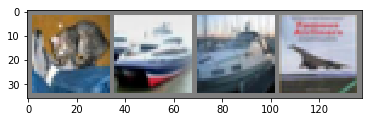

Ground-truth:   cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
print('Ground-truth:', ' '.join('%5s' % classes[labels[j]] for j in range(labels.shape[0])))

In [9]:
outputs = net(images)

In [10]:
_, predicted = torch.max(outputs, 1)
print('Prediction:', ' '.join('%5s' % classes[predicted[j]] for j in range(predicted.shape[0])))

Prediction:   cat  ship  ship  ship


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print("Accuracy of the network on the final 10000 images test set: %d %%" % (100 * correct / total))

Accuracy of the network on the final 10000 images test set: 52 %


In [12]:
# Compute class-wise accuracy
class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(predicted.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 55 %
Accuracy of   car : 51 %
Accuracy of  bird : 40 %
Accuracy of   cat : 27 %
Accuracy of  deer : 53 %
Accuracy of   dog : 64 %
Accuracy of  frog : 52 %
Accuracy of horse : 53 %
Accuracy of  ship : 82 %
Accuracy of truck : 45 %


# TRAINING ON GPU

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# Move the network to the GPU
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
# The tensors also needs to be transported to the GPU
images, labels = images.to(device), labels.to(device)

# MULTI-GPU TRAINING

In [16]:
# Training on multple GPUs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for training!")
    # Batch dim will be distributed equally among GPUs
    # [30, x] -> [10, x], [10, x], [10, x] on 3 GPUs
    net = nn.DataParallel(net)

net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)